# Chalearn Data Analysis using Features extracted using VGG Face 
* Features are from the fc6 layer which outputs a 4096-d vector per frame.
So its a concatenation of min, max, mean and std of all frames in the 
input video. (4096x4 = 16384)

In [1]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import scipy.io as spio
import pandas as pd


from VGG_analysis_helper import *

## 1) Import Data


In [2]:
# Train
mat = spio.loadmat('VGGFTfeaturesTrain.mat', squeeze_me=True)
X_train = pd.DataFrame(mat['Features'])
Y_train = pd.DataFrame(createY_train(pd.DataFrame(mat['VideoList'])))

# Remove first 1068 features since they are all zeros 
X_train.drop(X_train.head(1068).index, inplace=True)
X_train = X_train.reset_index(drop=True)

print(len(X_train))
print(len(Y_train))

4932
4932


In [3]:
# Validation
mat = spio.loadmat('VGGFTfeaturesValidation.mat', squeeze_me=True)

X_valid = pd.DataFrame(mat['Features'])

Y_valid = pd.DataFrame(createY_valid(pd.DataFrame(mat['VideoList']) ))
print(len(X_valid))
print(len(Y_valid))

2000
2000


In [4]:
#Test
mat = spio.loadmat('VGGFTfeaturesTest.mat', squeeze_me=True)

X_test = pd.DataFrame(mat['Features'])

Y_test = pd.DataFrame(createY_test(pd.DataFrame(mat['VideoList']) ))
print(len(X_test))
print(len(Y_test))

1840
1840


## 2) PCA

number of components =  458


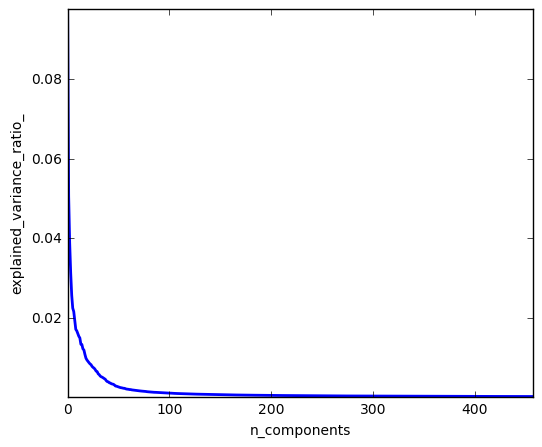

In [5]:
from sklearn.decomposition import PCA
X_train_pca, X_valid_pca = peform_PCA(X_train, X_valid, 0.85) 

## 3) Training

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve

# Plot the ROC curve and return AUC
def plotROC(y_test, y_pred):    
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    auc = roc_auc_score(y_test, y_pred)  # AUC metric
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    plt.plot([0, 1], [0, 1], 'k--')

    plt.show()

## Random Forest Classifier

In [7]:
# No PCA, train and valid sets
'''
from sklearn.ensemble import RandomForestClassifier
print("lelo")
regr = RandomForestClassifier(n_estimators=400, min_samples_leaf=50, n_jobs=-1)
regr.fit(X_train_pca, Y_train.values.ravel())
score = cross_val_score(regr, X_train_pca, Y_train.values.ravel(), cv=5)
print(score)
print(np.mean(score))
'''
#y_pred_rf = regr.predict_proba(X_valid)[:,1] 
#plotROC(Y_valid, y_pred_rf)

'\nfrom sklearn.ensemble import RandomForestClassifier\nprint("lelo")\nregr = RandomForestClassifier(n_estimators=400, min_samples_leaf=50, n_jobs=-1)\nregr.fit(X_train_pca, Y_train.values.ravel())\nscore = cross_val_score(regr, X_train_pca, Y_train.values.ravel(), cv=5)\nprint(score)\nprint(np.mean(score))\n'

## Multiple models

In [8]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, SelectPercentile, VarianceThreshold, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,  GradientBoostingClassifier, RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


models_names = ['Logistic Regression',
                'Decision Tree',
                'Bernoulli Naive Bayes',
                'Gaussian Naive Bayes', 
                'Random Forest',
                'Ada Boost',
                'Gradient Boosting',
                'Neural Network',
               'KNeighborsClassifier(n_neighbors=3)']

models = [LogisticRegression(),
          tree.DecisionTreeClassifier(min_samples_leaf=4),
          BernoulliNB(),
          GaussianNB(),
          RandomForestClassifier(n_estimators=400, min_samples_leaf=4, n_jobs=-1), 
          AdaBoostClassifier(), 
          GradientBoostingClassifier(),
          MLPClassifier(max_iter = 10000, alpha = 1e-3, hidden_layer_sizes=(100, 100)
),
          KNeighborsClassifier(n_neighbors=2)]


features_names = ['All']

features = [(X_train_pca, X_valid_pca)]
# Benchmark classifiers
def benchmark(clf, train_X, test_X):
    Y_train_df = pd.DataFrame(Y_train)
    Y_valid_df = pd.DataFrame(Y_valid)

    
    clf.fit(train_X, Y_train_df.values.ravel())
    
    pred = clf.predict(test_X)
    
    score = cross_val_score(clf, test_X, Y_valid_df.values.ravel(), cv=5)
    
    cm = confusion_matrix(Y_valid_df.values.ravel(),pred)
    
    fpr, tpr, thresholds = roc_curve(Y_valid_df, pred)
    
    roc_auc = auc(fpr, tpr)
    return roc_auc, np.mean(score)

Training
one loop
one loop
one loop
one loop
one loop
one loop
one loop
one loop
one loop
completed


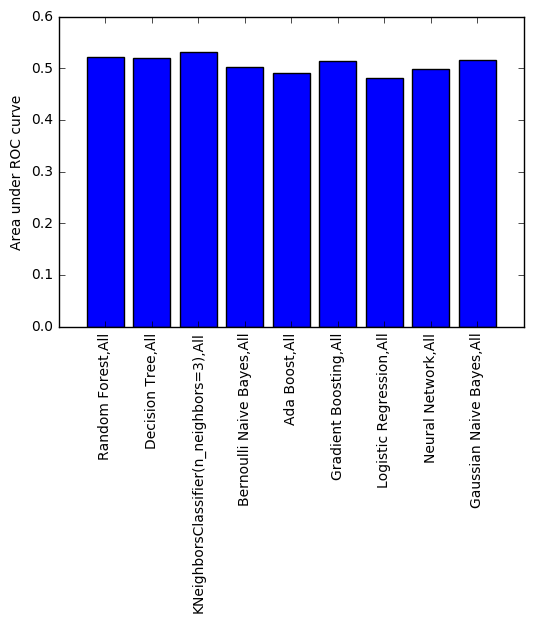

In [9]:
acc_train = {}
auc_train = {}
print('Training')
for clf, name in zip(models, models_names):
    for feat, feat_name in zip(features, features_names):
        final_n = name + ',' + feat_name
        auc_train[final_n], acc_train[final_n] = benchmark(clf, feat[0], feat[1])
        print('one loop')
print('completed')

auc_sort= sorted(auc_train.items(), key=lambda x: x[1], reverse = True)
auc_sort = dict(auc_sort[:15])
plt.bar(range(len(auc_sort)), auc_sort.values(), align='center')
plt.ylabel('Area under ROC curve')
plt.xticks(range(len(auc_sort)), list(auc_sort.keys()), rotation='vertical')
plt.show()

Iteration 1, loss = 4.82016985
Iteration 2, loss = 1.53470178
Iteration 3, loss = 1.56099556
Iteration 4, loss = 1.53858769
Iteration 5, loss = 1.51498713
Iteration 6, loss = 1.49371568
Iteration 7, loss = 1.47459513
Iteration 8, loss = 1.45748232
Iteration 9, loss = 1.44075676
Iteration 10, loss = 1.42578023
Iteration 11, loss = 1.41183781
Iteration 12, loss = 1.39794176
Iteration 13, loss = 1.38565292
Iteration 14, loss = 1.37383812
Iteration 15, loss = 1.36252892
Iteration 16, loss = 1.35135061
Iteration 17, loss = 1.34178162
Iteration 18, loss = 1.33155596
Iteration 19, loss = 1.32206986
Iteration 20, loss = 1.31290231
Iteration 21, loss = 1.30422035
Iteration 22, loss = 1.29573088
Iteration 23, loss = 1.28775568
Iteration 24, loss = 1.27992484
Iteration 25, loss = 1.27289024
Iteration 26, loss = 1.26562638
Iteration 27, loss = 1.25879523
Iteration 28, loss = 1.25153129
Iteration 29, loss = 1.24473366
Iteration 30, loss = 1.23916540
Iteration 31, loss = 1.23177157
Iteration 32, los

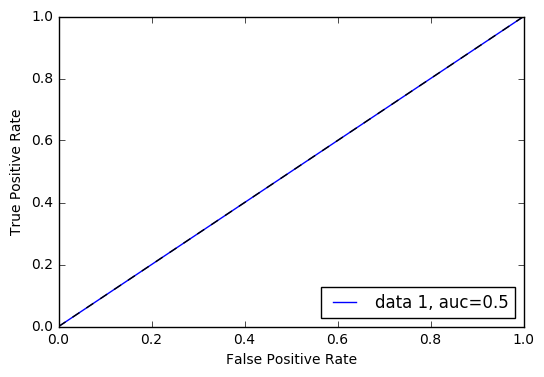

In [16]:
# Using MLP on Train and test data
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=10000, alpha=1e-3,
                    solver ='adam', verbose=10, tol=1e-3, random_state=1,
                    learning_rate_init=.1)

mlp.fit(X_train, Y_train.values.ravel())

pred = mlp.predict_proba(X_test)[:,1] 
plotROC(Y_test, pred)

Iteration 1, loss = 4.82016985
Iteration 2, loss = 1.53470178
Iteration 3, loss = 1.56099556
Iteration 4, loss = 1.53858769
Iteration 5, loss = 1.51498713
Iteration 6, loss = 1.49371568
Iteration 7, loss = 1.47459513
Iteration 8, loss = 1.45748232
Iteration 9, loss = 1.44075676
Iteration 10, loss = 1.42578023
Iteration 11, loss = 1.41183781
Iteration 12, loss = 1.39794176
Iteration 13, loss = 1.38565292
Iteration 14, loss = 1.37383812
Iteration 15, loss = 1.36252892
Iteration 16, loss = 1.35135061
Iteration 17, loss = 1.34178162
Iteration 18, loss = 1.33155596
Iteration 19, loss = 1.32206986
Iteration 20, loss = 1.31290231
Iteration 21, loss = 1.30422035
Iteration 22, loss = 1.29573088
Iteration 23, loss = 1.28775568
Iteration 24, loss = 1.27992484
Iteration 25, loss = 1.27289024
Iteration 26, loss = 1.26562638
Iteration 27, loss = 1.25879523
Iteration 28, loss = 1.25153129
Iteration 29, loss = 1.24473366
Iteration 30, loss = 1.23916540
Iteration 31, loss = 1.23177157
Iteration 32, los

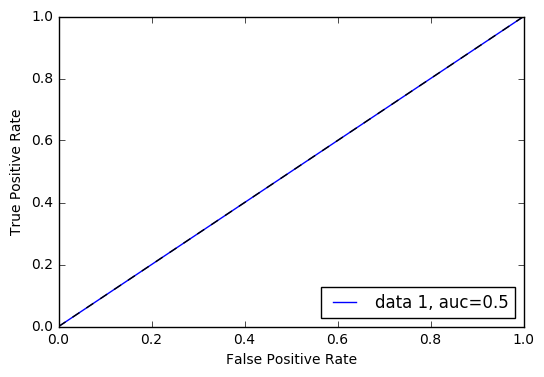

In [17]:
# using MLPs on train data only
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=10000, alpha=1e-3,
                    solver ='adam', verbose=10, tol=1e-3, random_state=1,
                    learning_rate_init=.1)

mlp.fit(X_train, Y_train.values.ravel())

pred = mlp.predict_proba(X_train)[:,1] 
plotROC(Y_train, pred)

Iteration 1, loss = 9.41631475
Iteration 2, loss = 4.44501768
Iteration 3, loss = 1.45422908
Iteration 4, loss = 1.53548908
Iteration 5, loss = 1.56776975
Iteration 6, loss = 1.57278805
Training loss did not improve more than tol=0.001000 for two consecutive epochs. Stopping.


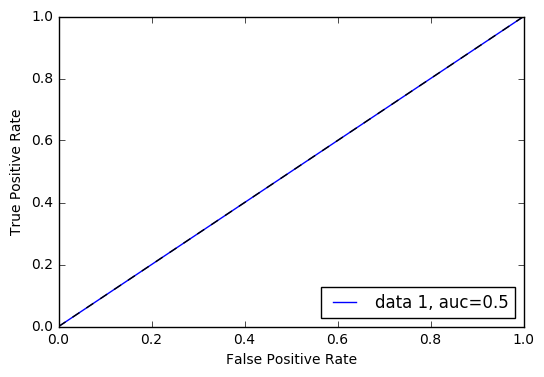

In [18]:
# using MLPs on validation data only

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=10000, alpha=1e-3,
                    solver ='adam', verbose=10, tol=1e-3, random_state=1,
                    learning_rate_init=.1)

mlp.fit(X_valid, Y_valid.values.ravel())

pred = mlp.predict_proba(X_valid)[:,1] 
plotROC(Y_valid, pred)

In [22]:
from sklearn.ensemble import RandomForestClassifier
print("lelo")
regr = RandomForestClassifier(n_estimators=400, min_samples_leaf=50, n_jobs=-1)
regr.fit(X_valid, Y_valid.values.ravel())
score = cross_val_score(regr, X_valid, Y_valid.values.ravel(), cv=5)
print(score)
print(np.mean(score))

regr = RandomForestClassifier(n_estimators=400, min_samples_leaf=50, n_jobs=-1)
regr.fit(X_train, Y_train.values.ravel())
score = cross_val_score(regr, X_train, Y_train.values.ravel(), cv=5)
print(score)
print(np.mean(score))

lelo
[ 0.70822943  0.7         0.6425      0.675       0.68170426]
0.681486737417
[ 0.55116515  0.55724417  0.55217832  0.53346856  0.55837563]
0.550486366733
